In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# DataFrames 
players = pd.read_csv("datasets/players.csv")
players_stats = pd.read_csv("datasets/player_szn_stats.csv")
nba_teams = pd.read_csv("datasets/teams.csv")
szn_types = pd.read_csv("datasets/szn_types.csv")
szn_stats = pd.read_csv("datasets/Seasons_Stats.csv") 


In [19]:
def clean_name(s: str):
    """
    cleans the name of the players, in the szn stats dataset some have a '*' at the end of their name
    """
    if isinstance(s, str) and s.endswith("*"):
        return s[:-1]
    return s

In [20]:
szn_stats["Player"] = szn_stats["Player"].apply(clean_name)

In [143]:
merged = players_stats.merge(nba_teams, on="team_id")
merged = merged.merge(players, on="player_id")
merged["player_name"] = merged["first_name"] + " " + merged["last_name"]
merged = merged[["player_id", "full_name", "player_name", "season_id", "league_id_x"]].drop_duplicates()
merged = merged[merged["league_id_x"] == 0]


Index(['player_id', 'team_id', 'season_id', 'minutes', 'games_started',
       'games_played', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'ast', 'stl',
       'blk', 'tov', 'pts', 'orb', 'drb', 'trb', 'pf', 'season_type_id',
       'league_id_x', 'league_id_y', 'full_name', 'nba_player_id',
       'date_of_birth', 'first_name', 'last_name', 'height_inches',
       'weight_lb', 'player_name'],
      dtype='object')


### Descriptive analysis of the dataset

Lets take a look at who are the players and teams that have performed the best over the years. For this analysis we will only be looking at the NBA, and regular season statistics.


In [145]:
player_with_teams = szn_stats.merge(merged, left_on=["Player", "Year"], right_on=["player_name", "season_id"], how="left").sort_values(by="Year").dropna(subset=["Year"])
player_with_teams = player_with_teams.drop_duplicates(subset=["Player", "Year"])

## Players

<Axes: title={'center': 'Top Scoring players'}, xlabel='Player', ylabel='Points'>

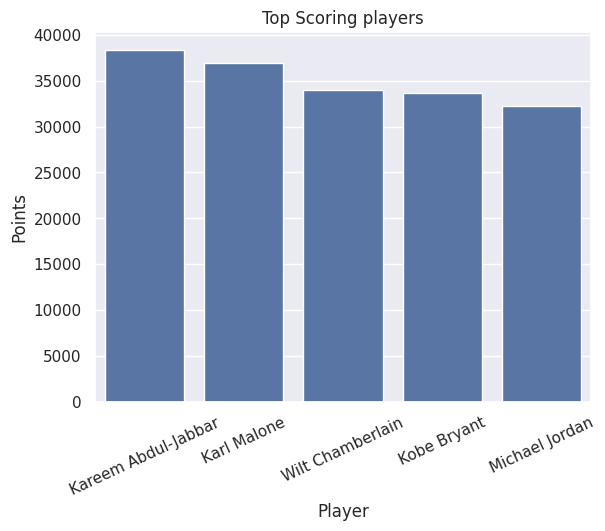

In [158]:
def get_top_scoring_players(players):
    """
    returns the top scoring players in the dataset
    """
    return players.groupby("Player").sum().sort_values(by="PTS", ascending=False)

def plot_top_scoring_players(players):
    """
    returns an axis plotting the top scoring players in the dataset
    """
    top_scoring_players = get_top_scoring_players(players).head(5).reset_index() 
    plot = sns.barplot(data=top_scoring_players, y="PTS", x="Player")
    plot.set(title="Top Scoring players", ylabel="Points")
    plot.tick_params(axis="x", rotation=25)
    return plot

szn_stats_test = szn_stats.iloc[10000:10010]
assert get_top_scoring_players(szn_stats_test).index.to_list() == ['James Worthy', 'Mahmoud Abdul-Rauf', 'Orlando Woolridge',
       'Mike Woodson', 'Danny Young', 'Mark Acres', 'Michael Young',
       'Alaa Abdelnaby', 'Haywoode Workman']
plot_top_scoring_players(szn_stats)

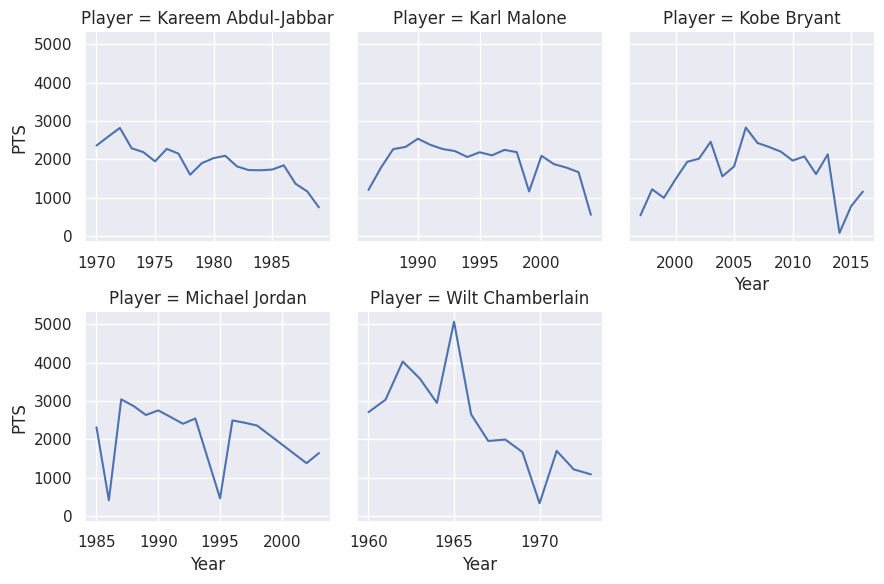

In [165]:
def plot_top_scoring_players_over_time(players):
    """"
    returns an axis with 5 subplots of the top scoring players over time in the dataset
    """
    top_players = get_top_scoring_players(players).head(5).sort_values(by="PTS").index
    players_per_year = szn_stats[szn_stats["Player"].isin(top_players)].groupby(["Player", "Year"]).sum().reset_index()
    g = sns.FacetGrid(players_per_year, col="Player", sharex=False, col_wrap=3)
    g.map(sns.lineplot, "Year", "PTS")
    return g

plot_top_scoring_players_over_time(szn_stats)


But are these really the best players? What if a player or team has played more games. Let's take a look at averages during the years, and see if there is anything that changes. 

<Axes: title={'center': 'Avg points scored per season all time'}, xlabel='Player', ylabel='Points'>

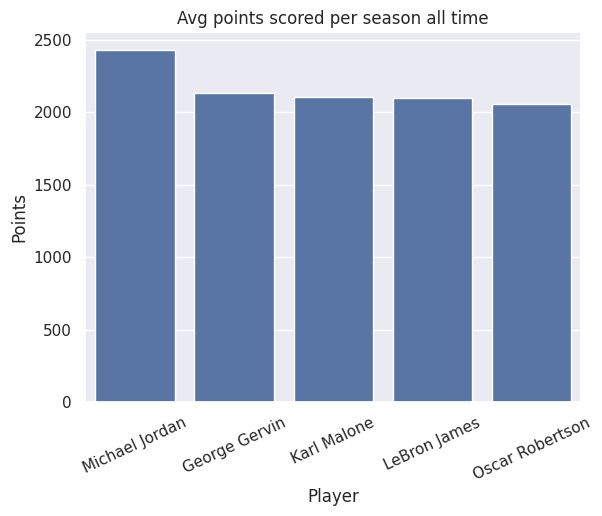

In [169]:
def get_avg_scoring_players(players):
    """
    returns the average points scored by players in the dataset
    """
    return players[["Player", "PTS"]].groupby("Player").median().sort_values(by="PTS", ascending=False)

def get_players_with_highest_pts_avg(players): 
    """
    returns an axis with the top 5 players with the highest average points scored per season all time
    """
    avg_top_scoring_players = get_avg_scoring_players(players).head(5)
    plot = sns.barplot(data=avg_top_scoring_players.reset_index(), y="PTS", x="Player")
    plot.set(title="Avg points scored per season all time", xlabel="Player", ylabel="Points")
    plot.tick_params(axis="x", rotation=25)
    return plot

assert get_avg_scoring_players(szn_stats_test).index.to_list() == ['James Worthy', 'Mahmoud Abdul-Rauf', 'Orlando Woolridge',
       'Mike Woodson', 'Danny Young', 'Mark Acres', 'Michael Young',
       'Alaa Abdelnaby', 'Haywoode Workman']

get_players_with_highest_pts_avg(szn_stats)

## Who have been the best shooters? (True shooting %)

True shooting percentage shows who have been the best shooters across all possible scoring types.

True shooting percentage is defined as

$$ TS\% = {PTS \over 2FGA + 0.475FTA} $$ 



           Player     GS        TS%
0   Artis Gilmore  503.0  63.115459
1  DeAndre Jordan  561.0  61.854219
2  Cedric Maxwell  568.0  61.694717
3  Tyson Chandler  829.0  61.384457
4   Stephen Curry  568.0  61.183466


<Axes: title={'center': 'Top 5 shooters all time'}, xlabel='Player', ylabel='True Shooting Percentage'>

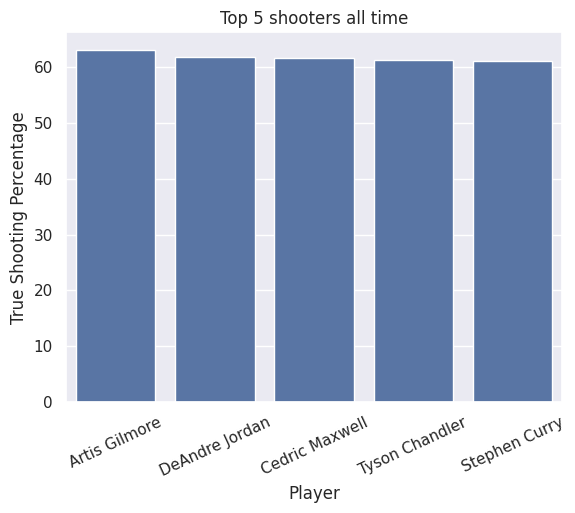

In [180]:
def get_players_true_shooting_percentages(players):
    """
    returns a dataframe with the true shooting percentages of players in the dataset
    """
    players_w_tshooting= players[["Player", "FGA", "FTA", "PTS", "GS", "Year"]].groupby("Player").sum().sort_values(by="PTS", ascending=False)
    players_w_tshooting['TS%'] = (players_w_tshooting['PTS'] / (2 * (players_w_tshooting['FGA'] + 0.475 * players_w_tshooting['FTA']))) * 100
    return players_w_tshooting

def plot_best_true_shooters(players):
    """
    returns an axis with the top 5 players with the highest true shooting percentage all time
    """
    best_shooters = get_players_true_shooting_percentages(players)
    best_shooters = best_shooters[best_shooters["GS"] > 250][["GS","TS%"]].sort_values(by="TS%", ascending=False).head(5).reset_index()
    plot = sns.barplot(data=best_shooters, y="TS%", x="Player")
    plot.tick_params(axis="x", rotation=25)
    plot.set(title="Top 5 shooters all time", xlabel="Player", ylabel="True Shooting Percentage", )
    print(best_shooters.head(5))
    return plot


assert get_players_true_shooting_percentages(szn_stats_test)["TS%"].to_list() == [58.160606112904055, 44.621287480460424, 59.337349397590366, 44.18526410227655, 50.23609653725079, 54.39450329229888, 51.638764442348496, 49.30606281957633, 75.94936708860759]
plot_best_true_shooters(szn_stats)

## Effective field goal percentage

it shows how efficient the player is at shooting three point shots and also 2 point shots

and it is defined as follows:

$$ eFG\% = {FG + 0.5\times3PM \over FGA}$$

<Axes: title={'center': 'Top 5 players with effective field goal percentage'}, xlabel='Player', ylabel='eFG%'>

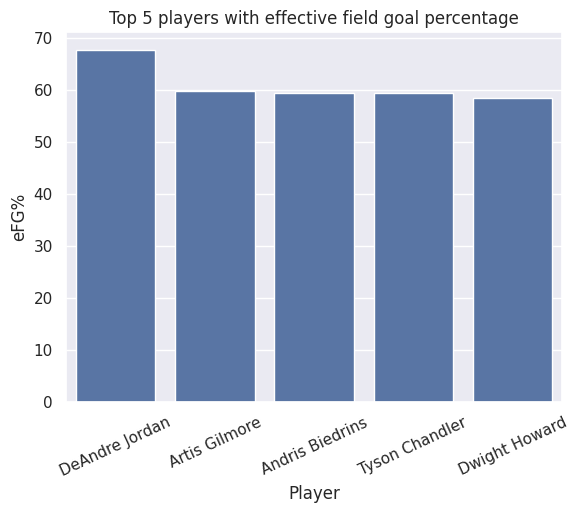

In [184]:
def get_players_effective_field_goal_percentage(players):
    """
    returns a dataframe with the effective field goal percentages of players in the dataset
    """
    players_w_efg = players[["Player", "FG", "FGA", "Year", "3P", "GS"]].groupby("Player").sum().sort_values(by="FG", ascending=False)
    players_w_efg["eFG%"] = ((players_w_efg["FG"] + 0.5 * players_w_efg["3P"]) / players_w_efg["FGA"]) * 100
    return players_w_efg

def plot_effective_fild_goal_percentage(players):
    """
    returns an axis with the top 5 players with the highest effective field goal percentage all time in the dataset
    """
    best_efg_players = get_players_effective_field_goal_percentage(players)
    best_efg_players = best_efg_players[best_efg_players["GS"] > 250][["GS", "eFG%"]].sort_values(by="eFG%", ascending=False)
    plot = sns.barplot(data=best_efg_players.reset_index().head(5), y="eFG%", x="Player")
    plot.set(title="Top 5 players with effective field goal percentage", xlabel="Player", ylabel="eFG%")
    plot.tick_params(axis="x", rotation=25)
    return plot

assert get_players_effective_field_goal_percentage(szn_stats_test)["eFG%"].head(5).to_list() == [55.354391371340526, 42.51734390485629, 55.63636363636364, 40.98765432098765, 44.51219512195122]
plot_effective_fild_goal_percentage(szn_stats)

Note that, it is interesting that our best shooters, are not in the part of the players with highest average points scored per season

## Teams 

lets analyse who have been the most dominants teams over the years

<Axes: title={'center': 'Top Scoring teams all Time'}, xlabel='Team', ylabel='Total Points'>

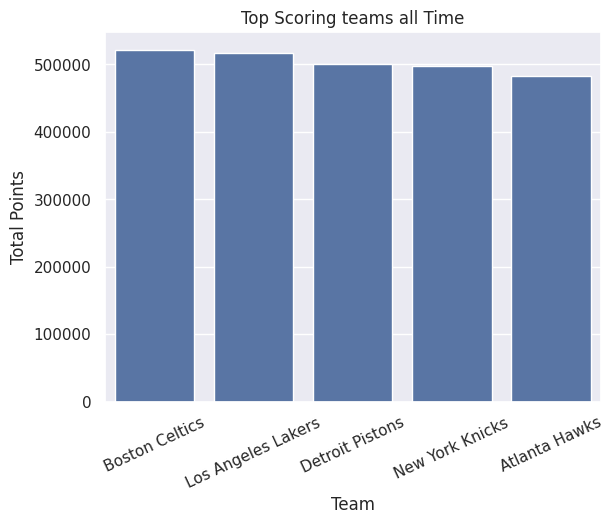

In [188]:
def get_top_scoring_teams(players):
    """
    returns the top scoring teams all time in the dataset
    """
    return players.groupby("full_name").sum().sort_values(by="PTS", ascending=False)

def plot_top_scoring_teams(players):
    """
    returns an axes with the top scoring teams all time as of 2020
    """
    top_scoring_teams = get_top_scoring_teams(players)
    plot = sns.barplot(data=top_scoring_teams.reset_index().head(5), y="PTS", x="full_name")
    plot.set(title="Top Scoring teams all Time", xlabel="Team", ylabel="Total Points")
    plot.tick_params(axis="x", rotation=25)

    return plot

plot_top_scoring_teams(player_with_teams)

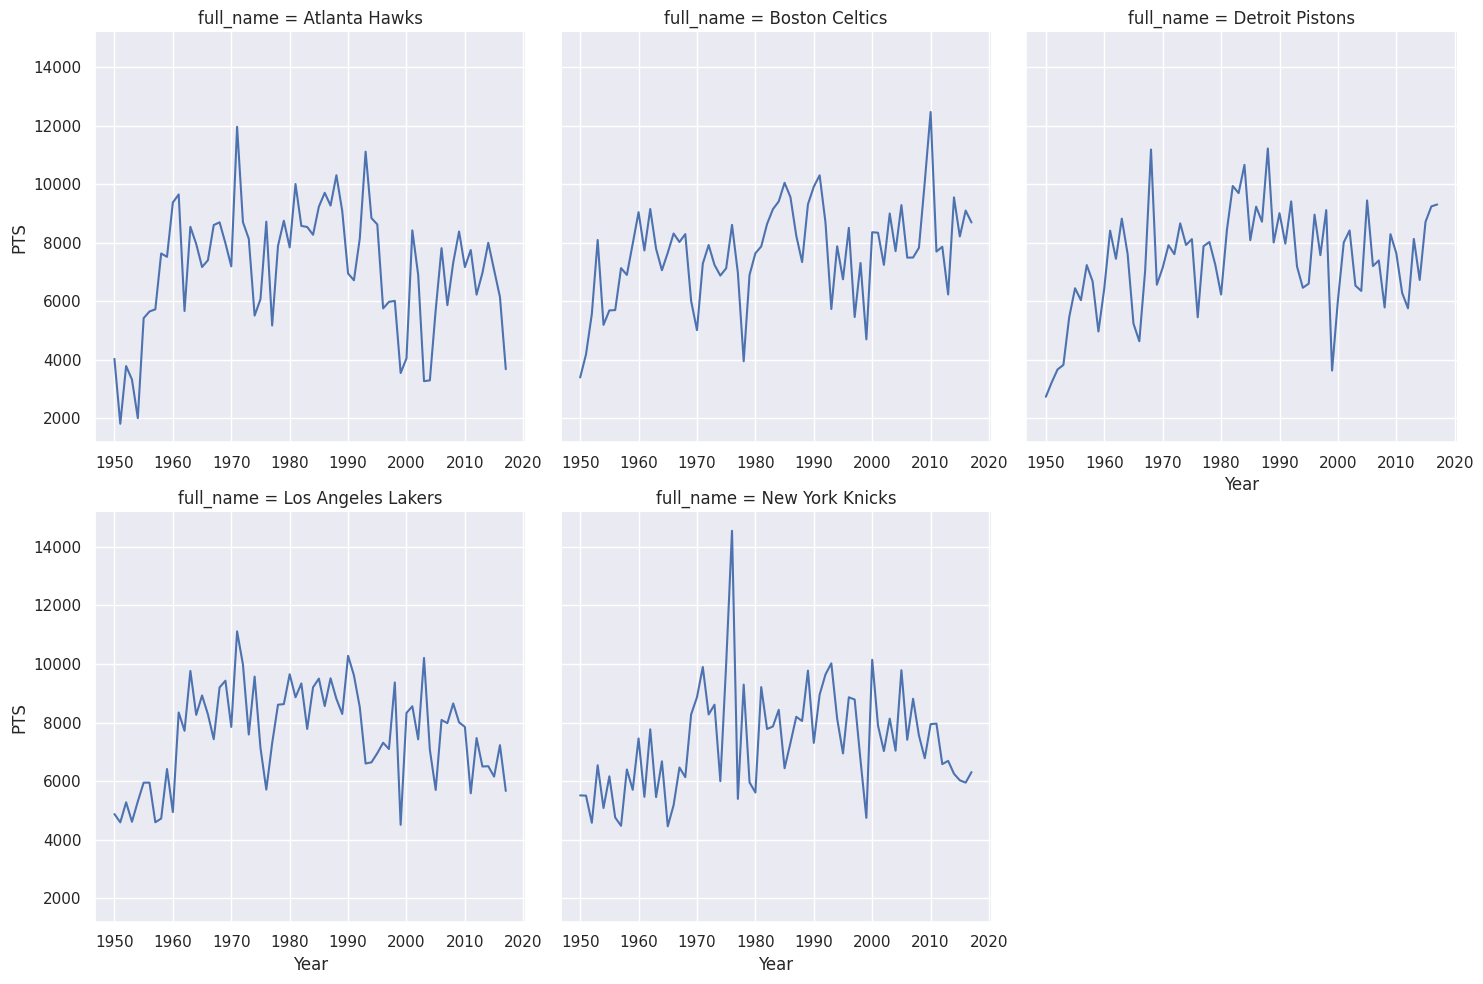

In [191]:
def plot_top_scoring_teams_over_time(players):
    """
    returns an axis with the top 5 scoring teams over time in the dataset
    """
    top_teams = get_top_scoring_teams(players).head(5).index
    team_points_per_year = players[players["full_name"].isin(top_teams)].groupby(["full_name", "Year"]).sum().reset_index()
    plot = sns.FacetGrid(data=team_points_per_year, col="full_name", col_wrap=3, height=5, sharex=False)
    plot.map(sns.lineplot, "Year", "PTS")
    return plot

plot_top_scoring_teams_over_time(player_with_teams)

## Assists to turnover ratio

It is said that elite teams are the ones producing the most amounts of assists and the least turnovers, lets take a look at which teams have been the best at doing so over the years 

In [192]:
def teams_w_best_ast_tov_ration(players):
    """
    returns a dataframe with the teams with the best assist to turnover ratio
    """
    teams_per_year = players[players["Year"] > 2000][["full_name", "TOV", "AST", "G"]].groupby("full_name").sum().reset_index()
    teams_per_year = teams_per_year[teams_per_year["TOV"] > 0]
    teams_per_year["AST/TOV"] = teams_per_year["AST"] / teams_per_year["TOV"]
    teams_per_year = teams_per_year[teams_per_year["G"] > 10000]
    teams_per_year = teams_per_year.sort_values(by="AST/TOV", ascending=False)
    print(teams_per_year.head(10))

teams_w_best_ast_tov_ration(player_with_teams)

                 full_name      TOV      AST        G   AST/TOV
7         Dallas Mavericks  17935.0  30831.0  13563.0  1.719041
27       San Antonio Spurs  18475.0  31226.0  14120.0  1.690176
3        Charlotte Hornets  14380.0  23564.0  10877.0  1.638665
28         Toronto Raptors  16940.0  27742.0  13321.0  1.637662
29               Utah Jazz  16943.0  27693.0  11910.0  1.634480
2            Brooklyn Nets  16096.0  26298.0  12053.0  1.633822
14      Los Angeles Lakers  16705.0  27247.0  11614.0  1.631069
9          Detroit Pistons  16943.0  27519.0  12810.0  1.624211
18  Minnesota Timberwolves  17192.0  27630.0  12219.0  1.607143
24            Phoenix Suns  16461.0  26384.0  11031.0  1.602819


Interestingly enough, these teams do not seem to be the most successful ones the NBA.